# Big Data Management Project 4:
## Airline Delay and Cancellation Prediction with Spark ML


### Imports & Setup

### 1. Data Ingestion and Preparation

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("BDM_Project4") \
    .getOrCreate()

In [2]:
df2009 = (spark.read
      .option("header", "true")
      .option("inferSchema", "true")
      .csv("input/2009.csv"))
df2009.printSchema()
df2009.show(5)

root
 |-- FL_DATE: date (nullable = true)
 |-- OP_CARRIER: string (nullable = true)
 |-- OP_CARRIER_FL_NUM: integer (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- CRS_DEP_TIME: integer (nullable = true)
 |-- DEP_TIME: double (nullable = true)
 |-- DEP_DELAY: double (nullable = true)
 |-- TAXI_OUT: double (nullable = true)
 |-- WHEELS_OFF: double (nullable = true)
 |-- WHEELS_ON: double (nullable = true)
 |-- TAXI_IN: double (nullable = true)
 |-- CRS_ARR_TIME: integer (nullable = true)
 |-- ARR_TIME: double (nullable = true)
 |-- ARR_DELAY: double (nullable = true)
 |-- CANCELLED: double (nullable = true)
 |-- CANCELLATION_CODE: string (nullable = true)
 |-- DIVERTED: double (nullable = true)
 |-- CRS_ELAPSED_TIME: double (nullable = true)
 |-- ACTUAL_ELAPSED_TIME: double (nullable = true)
 |-- AIR_TIME: double (nullable = true)
 |-- DISTANCE: double (nullable = true)
 |-- CARRIER_DELAY: double (nullable = true)
 |-- WEATHER_DELAY: doub

#### Save as parquet, partitioned by extracted month

In [3]:
from pyspark.sql.functions import col, month, dayofweek

df2009 = df2009.withColumn("Month", month(col("FL_DATE")))
df2009 = df2009.withColumn("DayOfWeek", dayofweek(col("FL_DATE")))
df2009.write.mode("overwrite").partitionBy("Month").parquet("/home/jovyan/input/2009_parquet/")

### 2. Cleaning and Preprocessing

In [4]:
df2009 = df2009.drop("Unnamed: 27")

df2009 = df2009.withColumnRenamed("OP_CARRIER", "UniqueCarrier")
df2009 = df2009.withColumnRenamed("OP_CARRIER_FL_NUM", "UniqueCarrierFlightNumber")

df2009_cleaned = df2009.dropna(subset=['FL_DATE', 'UniqueCarrier'])

df2009_cleaned = df2009_cleaned.filter(col("DIVERTED") == 0.0)

df2009_cleaned = df2009_cleaned.withColumn("Month", month("FL_DATE")) \
                                 .withColumn("DayOfWeek", dayofweek("FL_DATE"))

### 3. Exploratory Analysis

In [5]:
df2009_cleaned.groupBy("CANCELLED").count().show()

+---------+------+
|CANCELLED| count|
+---------+------+
|      0.0|123691|
|      1.0|  2183|
+---------+------+



In [6]:
cancelled = df2009_cleaned.filter(df2009_cleaned["CANCELLED"] == 1.0)
cancelled.count()

2183

In [7]:
# Top 10 carriers by number of flights
top_10_carriers = cancelled.groupBy("UniqueCarrier").count().orderBy("count", ascending=False).limit(10)
top_10_carriers.show()

+-------------+-----+
|UniqueCarrier|count|
+-------------+-----+
|           WN|  295|
|           OO|  252|
|           MQ|  213|
|           EV|  202|
|           AA|  192|
|           US|  147|
|           9E|  147|
|           UA|  113|
|           DL|  100|
|           XE|   99|
+-------------+-----+



In [8]:
# Count cancellation reasons
cancel_reasons = cancelled.groupBy("CANCELLATION_CODE").count().orderBy("count", ascending=False)
cancel_reasons.show()

+-----------------+-----+
|CANCELLATION_CODE|count|
+-----------------+-----+
|                A|  933|
|                B|  862|
|                C|  388|
+-----------------+-----+



From Kaggle:
Reason for Cancellation of flight:
A - Airline/Carrier;
B - Weather;
C - National Air System;
D - Security

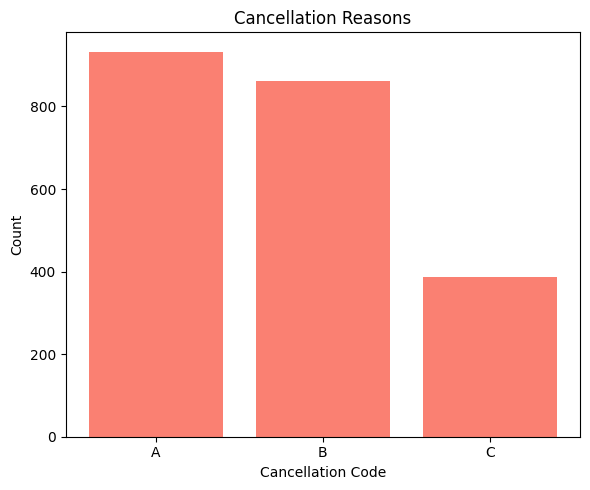

In [9]:
import matplotlib.pyplot as plt
cancel_reasons_pd = cancel_reasons.toPandas()

plt.figure(figsize=(6,5))
plt.bar(cancel_reasons_pd["CANCELLATION_CODE"], cancel_reasons_pd["count"], color='salmon')
plt.xlabel("Cancellation Code")
plt.ylabel("Count")
plt.title("Cancellation Reasons")
plt.tight_layout()
plt.show()

In [10]:
from pyspark.sql.functions import concat_ws

df2009_cleaned.withColumn("Route", concat_ws("->", "ORIGIN", "DEST")) \
               .groupBy("Route").count().orderBy("count", ascending=False).show(10)

+--------+-----+
|   Route|count|
+--------+-----+
|OGG->HNL|  252|
|HNL->OGG|  245|
|SFO->LAX|  238|
|LAX->SFO|  229|
|HNL->LIH|  209|
|LGA->ORD|  208|
|ORD->LGA|  203|
|LIH->HNL|  202|
|LAS->LAX|  199|
|SAN->LAX|  199|
+--------+-----+
only showing top 10 rows



In [11]:
class_dist = df2009_cleaned.groupBy("CANCELLED").count()
class_dist.show()

counts = class_dist.collect()
class_counts = {row['CANCELLED']: row['count'] for row in counts}

imbalance_ratio = max(class_counts.values()) / min(class_counts.values())
print(f"Imbalance Ratio: {imbalance_ratio:.2f}")

+---------+------+
|CANCELLED| count|
+---------+------+
|      0.0|123691|
|      1.0|  2183|
+---------+------+

Imbalance Ratio: 56.66


In [ ]:
#4. Feature Engineering

In [ ]:
#Categorical features (UniqueCarrier, ORIGIN, DEST) were encoded using StringIndexer and OneHotEncoder. Numerical features (DEP_DELAY, ARR_DELAY, CRS_ELAPSED_TIME) were included directly. All features were combined into a single vector with VectorAssembler for use in modeling.

In [44]:
# === 4. Feature Engineering === Eidi

from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline

cat_cols = ["UniqueCarrier", "ORIGIN", "DEST"]
# DEP_DELAY ja ARR_DELAY jätsin välja, kuna need veerud sisaldavad
#tühistatud lendude (CANCELLED = 1.0) puhul puuduvaid väärtusi.
# Kui need jätta sisse, siis VectorAssembler
# df_prepared_clean = df_prepared.dropna(subset=assembler_inputs + ["CANCELLED"])
#viskab need read välja (Eemalab kõik read, kus mõni
#VectorAssembler sisend või 'CANCELLED' on null."
# Mudel ei saa õppida tühistatud lendude pealt.
# Kasutasin ainult CRS_ELAPSED_TIME, mis on kõigi lendude puhul olemas.
# ehk siis tehtniliselt, siia peab vaatama veerunimesid mille puhul
# tunnused oleks kõigi lendue puhul ka olemas, mitte null valuga
num_cols = ["CRS_ELAPSED_TIME", "CRS_DEP_TIME", "CRS_ARR_TIME"]


indexers = [StringIndexer(inputCol=col, outputCol=col + "_Index", handleInvalid="keep") for col in cat_cols]
encoders = [OneHotEncoder(inputCol=col + "_Index", outputCol=col + "_Vec", handleInvalid="keep") for col in cat_cols]

assembler_inputs = [col + "_Vec" for col in cat_cols] + num_cols
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features", handleInvalid="skip")

pipeline = Pipeline(stages=indexers + encoders + [assembler])

pipeline_model = pipeline.fit(df2009_cleaned)
df_prepared = pipeline_model.transform(df2009_cleaned)

df_prepared_clean = df_prepared.dropna(subset=assembler_inputs + ["CANCELLED"])

df_prepared_clean.select("features", "CANCELLED").show(5, truncate=False)



+--------------------------------------------------------------+---------+
|features                                                      |CANCELLED|
+--------------------------------------------------------------+---------+
|(581,[9,42,311,578,579,580],[1.0,1.0,1.0,62.0,1100.0,1202.0]) |0.0      |
|(581,[9,32,327,578,579,580],[1.0,1.0,1.0,82.0,1510.0,1632.0]) |0.0      |
|(581,[9,32,321,578,579,580],[1.0,1.0,1.0,70.0,1100.0,1210.0]) |0.0      |
|(581,[9,42,311,578,579,580],[1.0,1.0,1.0,77.0,1240.0,1357.0]) |0.0      |
|(581,[9,49,311,578,579,580],[1.0,1.0,1.0,105.0,1715.0,1900.0])|0.0      |
+--------------------------------------------------------------+---------+
only showing top 5 rows



In [35]:
df2009_cleaned.filter("CANCELLED = 1.0").select("CRS_ELAPSED_TIME", "CRS_DEP_TIME", "CRS_ARR_TIME").summary("count").show()


+-------+----------------+------------+------------+
|summary|CRS_ELAPSED_TIME|CRS_DEP_TIME|CRS_ARR_TIME|
+-------+----------------+------------+------------+
|  count|            2183|        2183|        2183|
+-------+----------------+------------+------------+



In [36]:
df_prepared.filter("CANCELLED = 1.0").select(*assembler_inputs).summary("count").show()


+-------+----------------+------------+------------+
|summary|CRS_ELAPSED_TIME|CRS_DEP_TIME|CRS_ARR_TIME|
+-------+----------------+------------+------------+
|  count|            2183|        2183|        2183|
+-------+----------------+------------+------------+



In [37]:
df_prepared_clean.groupBy("CANCELLED").count().show()


+---------+------+
|CANCELLED| count|
+---------+------+
|      0.0|123691|
|      1.0|  2183|
+---------+------+



In [38]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline

cat_cols = ["UniqueCarrier", "ORIGIN", "DEST"]
indexers = [StringIndexer(inputCol=col, outputCol=col + "_Index") for col in cat_cols]
encoders = [OneHotEncoder(inputCol=col + "_Index", outputCol=col + "_Vec") for col in cat_cols]

num_cols = ["DEP_DELAY", "ARR_DELAY", "CRS_ELAPSED_TIME"]

assembler_inputs = [col + "_Vec" for col in cat_cols] + num_cols
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")

# Pipeline
pipeline = Pipeline(stages=indexers + encoders + [assembler])
pipeline_model = pipeline.fit(df2009_cleaned)
df_prepared = pipeline_model.transform(df2009_cleaned)

df_prepared.select("features", "CANCELLED").show(5, truncate=False)


+------------------------------------------------------------+---------+
|features                                                    |CANCELLED|
+------------------------------------------------------------+---------+
|(575,[9,40,307,572,573,574],[1.0,1.0,1.0,-2.0,4.0,62.0])    |0.0      |
|(575,[9,30,323,572,573,574],[1.0,1.0,1.0,-1.0,-8.0,82.0])   |0.0      |
|(575,[9,30,317,572,573,574],[1.0,1.0,1.0,-1.0,-9.0,70.0])   |0.0      |
|(575,[9,40,307,572,573,574],[1.0,1.0,1.0,9.0,-12.0,77.0])   |0.0      |
|(575,[9,47,307,572,573,574],[1.0,1.0,1.0,-10.0,-38.0,105.0])|0.0      |
+------------------------------------------------------------+---------+
only showing top 5 rows



In [15]:
df_prepared.describe()
df_prepared.show()

+----------+-------------+-------------------------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+-----------------+--------+----------------+-------------------+--------+--------+-------------+-------------+---------+--------------+-------------------+-----+---------+-------------------+------------+----------+-----------------+----------------+----------------+--------------------+
|   FL_DATE|UniqueCarrier|UniqueCarrierFlightNumber|ORIGIN|DEST|CRS_DEP_TIME|DEP_TIME|DEP_DELAY|TAXI_OUT|WHEELS_OFF|WHEELS_ON|TAXI_IN|CRS_ARR_TIME|ARR_TIME|ARR_DELAY|CANCELLED|CANCELLATION_CODE|DIVERTED|CRS_ELAPSED_TIME|ACTUAL_ELAPSED_TIME|AIR_TIME|DISTANCE|CARRIER_DELAY|WEATHER_DELAY|NAS_DELAY|SECURITY_DELAY|LATE_AIRCRAFT_DELAY|Month|DayOfWeek|UniqueCarrier_Index|ORIGIN_Index|DEST_Index|UniqueCarrier_Vec|      ORIGIN_Vec|        DEST_Vec|            features|
+----------+-------------+-------------------------+------+----+------

In [ ]:
#5. Modeling

In [45]:
#5 modeling eidi
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Split the data into train and test sets
train_data, test_data = df_prepared.randomSplit([0.7, 0.3], seed=42)

#defining models
# Logistic Regression
lr = LogisticRegression(labelCol="CANCELLED", featuresCol="features")

# Decision Tree Classifier
dt = DecisionTreeClassifier(labelCol="CANCELLED", featuresCol="features")

# Random Forest Classifier
rf = RandomForestClassifier(labelCol="CANCELLED", featuresCol="features")

# Gradient-Boosted Tree Classifier
gbt = GBTClassifier(labelCol="CANCELLED", featuresCol="features")

In [46]:
# 3.evaluators eidi
evaluator_auc = BinaryClassificationEvaluator(labelCol="CANCELLED", metricName="areaUnderROC")
evaluator_acc = MulticlassClassificationEvaluator(labelCol="CANCELLED", metricName="accuracy")

In [47]:
# 4. Define parameter grids eidi
lr_grid = ParamGridBuilder().addGrid(lr.maxIter, [10, 50]).build()
dt_grid = ParamGridBuilder().addGrid(dt.maxDepth, [5, 10]).build()
rf_grid = ParamGridBuilder().addGrid(rf.numTrees, [10, 50]).build()
gbt_grid = ParamGridBuilder().addGrid(gbt.maxIter, [10, 50]).build()

In [48]:
# 5. CrossValidators eidi
cv_lr = CrossValidator(estimator=lr, estimatorParamMaps=lr_grid, evaluator=evaluator_auc, numFolds=3)
cv_dt = CrossValidator(estimator=dt, estimatorParamMaps=dt_grid, evaluator=evaluator_auc, numFolds=3)
cv_rf = CrossValidator(estimator=rf, estimatorParamMaps=rf_grid, evaluator=evaluator_auc, numFolds=3)
cv_gbt = CrossValidator(estimator=gbt, estimatorParamMaps=gbt_grid, evaluator=evaluator_auc, numFolds=3)

In [49]:
# 6. Train models eidi
lr_model = cv_lr.fit(train_data)
dt_model = cv_dt.fit(train_data)
rf_model = cv_rf.fit(train_data)
gbt_model = cv_gbt.fit(train_data)

In [51]:
# 7. predictions eidi
lr_pred = lr_model.transform(test_data)
dt_pred = dt_model.transform(test_data)
rf_pred = rf_model.transform(test_data)
gbt_pred = gbt_model.transform(test_data)


In [52]:
# 8. Evaluate eidi
results = []

def evaluate_model(name, predictions):
    accuracy = evaluator_acc.evaluate(predictions)
    auc = evaluator_auc.evaluate(predictions)
    results.append({"Model": name, "Accuracy": accuracy, "AUC": auc})
    print(f"{name} — Accuracy: {accuracy:.4f}, AUC: {auc:.4f}")

evaluate_model("Logistic Regression", lr_pred)
evaluate_model("Decision Tree", dt_pred)
evaluate_model("Random Forest", rf_pred)
evaluate_model("Gradient Boosted Trees", gbt_pred)

import pandas as pd
results_df = pd.DataFrame(results)
print(results_df)


Logistic Regression — Accuracy: 0.9824, AUC: 0.7150
Decision Tree — Accuracy: 0.9820, AUC: 0.5462
Random Forest — Accuracy: 0.9825, AUC: 0.6572
Gradient Boosted Trees — Accuracy: 0.9822, AUC: 0.6919
                    Model  Accuracy       AUC
0     Logistic Regression  0.982419  0.714982
1           Decision Tree  0.982048  0.546160
2           Random Forest  0.982471  0.657195
3  Gradient Boosted Trees  0.982233  0.691870


In [ ]:
#PART 6 EIDI

In [53]:
# AUC mõhjal on gbt_model.bestModel parem
best_tree_model = gbt_model.bestModel  # või rf_model.bestModel

importances = best_tree_model.featureImportances


In [54]:
feature_names = assembler.getInputCols()


In [55]:

feature_importance_list = list(zip(feature_names, importances))

sorted_features = sorted(feature_importance_list, key=lambda x: x[1], reverse=True)


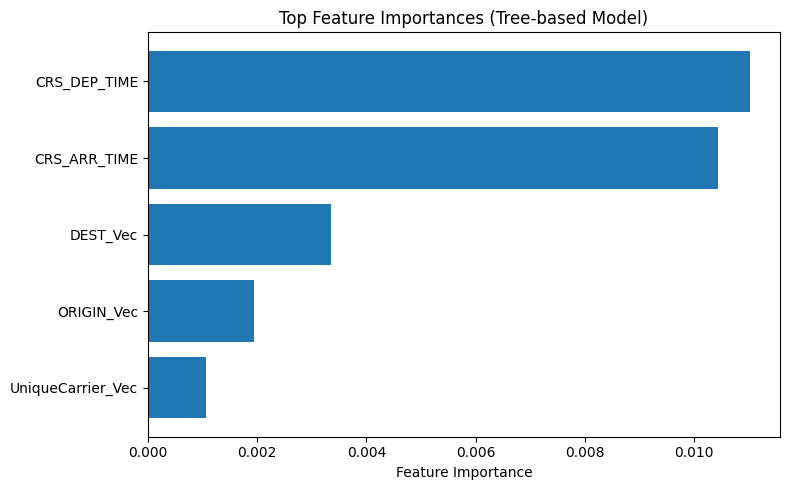

In [57]:
import matplotlib.pyplot as plt

top_k = 5
top_features = sorted_features[:top_k]

names = [f[0] for f in top_features]
scores = [f[1] for f in top_features]

plt.figure(figsize=(8, 5))
plt.barh(names[::-1], scores[::-1])
plt.xlabel("Feature Importance")
plt.title("Top Feature Importances (Tree-based Model)")
plt.tight_layout()
plt.show()


In [22]:
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Split the data into train and test sets
train_data, test_data = df_prepared.randomSplit([0.7, 0.3], seed=42)

# Logistic Regression
lr = LogisticRegression(labelCol="CANCELLED", featuresCol="features")

# Decision Tree Classifier
dt = DecisionTreeClassifier(labelCol="CANCELLED", featuresCol="features")

# Random Forest Classifier
rf = RandomForestClassifier(labelCol="CANCELLED", featuresCol="features")

# Gradient-Boosted Tree Classifier
gbt = GBTClassifier(labelCol="CANCELLED", featuresCol="features")


In [ ]:
# Evaluator
evaluator = BinaryClassificationEvaluator(labelCol="CANCELLED")

# Function to evaluate models
def evaluate_model(model, train_data, test_data):
    # Fit the model
    model_fitted = model.fit(train_data)

    # Predictions on test data
    predictions = model_fitted.transform(test_data)

    # AUC and Accuracy
    auc = evaluator.evaluate(predictions)
    accuracy = predictions.filter(predictions["CANCELLED"] == predictions["prediction"]).count() / float(predictions.count())

    return accuracy, auc

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Define the cross-validation evaluator
evaluator = BinaryClassificationEvaluator(labelCol="CANCELLED")

# Logistic Regression Hyperparameter Tuning
lr_param_grid = (ParamGridBuilder()
                 .addGrid(lr.maxIter, [10, 50, 100])
                 .build())
lr_cv = CrossValidator(estimator=lr, estimatorParamMaps=lr_param_grid, evaluator=evaluator, numFolds=3)

# Decision Tree Hyperparameter Tuning
dt_param_grid = (ParamGridBuilder()
                 .addGrid(dt.maxDepth, [5, 10, 15])
                 .build())
dt_cv = CrossValidator(estimator=dt, estimatorParamMaps=dt_param_grid, evaluator=evaluator, numFolds=3)

# Random Forest Hyperparameter Tuning
rf_param_grid = (ParamGridBuilder()
                 .addGrid(rf.numTrees, [10, 20, 50])
                 .build())
rf_cv = CrossValidator(estimator=rf, estimatorParamMaps=rf_param_grid, evaluator=evaluator, numFolds=3)

# GBT Hyperparameter Tuning
gbt_param_grid = (ParamGridBuilder()
                  .addGrid(gbt.maxIter, [10, 50, 100])
                  .build())
gbt_cv = CrossValidator(estimator=gbt, estimatorParamMaps=gbt_param_grid, evaluator=evaluator, numFolds=3)

In [ ]:
# Train models with cross-validation
lr_model = lr_cv.fit(train_data)
dt_model = dt_cv.fit(train_data)
rf_model = rf_cv.fit(train_data)
gbt_model = gbt_cv.fit(train_data)

# Evaluate models
lr_accuracy, lr_auc = evaluate_model(lr_model.bestModel, train_data, test_data)
dt_accuracy, dt_auc = evaluate_model(dt_model.bestModel, train_data, test_data)
rf_accuracy, rf_auc = evaluate_model(rf_model.bestModel, train_data, test_data)
gbt_accuracy, gbt_auc = evaluate_model(gbt_model.bestModel, train_data, test_data)

# Print results
print(f"Logistic Regression - Accuracy: {lr_accuracy}, AUC: {lr_auc}")
print(f"Decision Tree - Accuracy: {dt_accuracy}, AUC: {dt_auc}")
print(f"Random Forest - Accuracy: {rf_accuracy}, AUC: {rf_auc}")
print(f"GBT - Accuracy: {gbt_accuracy}, AUC: {gbt_auc}")

Py4JJavaError: An error occurred while calling o1865.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 1 in stage 77.0 failed 1 times, most recent failure: Lost task 1.0 in stage 77.0 (TID 80) (617e888bee8d executor driver): org.apache.spark.SparkException: [FAILED_EXECUTE_UDF] Failed to execute user defined function (`VectorAssembler$$Lambda$4372/0x00000008418db040`: (struct<UniqueCarrier_Vec:struct<type:tinyint,size:int,indices:array<int>,values:array<double>>,ORIGIN_Vec:struct<type:tinyint,size:int,indices:array<int>,values:array<double>>,DEST_Vec:struct<type:tinyint,size:int,indices:array<int>,values:array<double>>,DEP_DELAY:double,ARR_DELAY:double,CRS_ELAPSED_TIME:double>) => struct<type:tinyint,size:int,indices:array<int>,values:array<double>>).
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala:198)
	at org.apache.spark.sql.errors.QueryExecutionErrors.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.sort_addToSorter_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at org.apache.spark.sql.execution.columnar.DefaultCachedBatchSerializer$$anon$1.hasNext(InMemoryRelation.scala:119)
	at org.apache.spark.sql.execution.columnar.CachedRDDBuilder$$anon$2.hasNext(InMemoryRelation.scala:288)
	at org.apache.spark.storage.memory.MemoryStore.putIterator(MemoryStore.scala:223)
	at org.apache.spark.storage.memory.MemoryStore.putIteratorAsValues(MemoryStore.scala:302)
	at org.apache.spark.storage.BlockManager.$anonfun$doPutIterator$1(BlockManager.scala:1597)
	at org.apache.spark.storage.BlockManager.org$apache$spark$storage$BlockManager$$doPut(BlockManager.scala:1524)
	at org.apache.spark.storage.BlockManager.doPutIterator(BlockManager.scala:1588)
	at org.apache.spark.storage.BlockManager.getOrElseUpdate(BlockManager.scala:1389)
	at org.apache.spark.storage.BlockManager.getOrElseUpdateRDDBlock(BlockManager.scala:1343)
	at org.apache.spark.rdd.RDD.getOrCompute(RDD.scala:379)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: org.apache.spark.SparkException: Encountered null while assembling a row with handleInvalid = "error". Consider
removing nulls from dataset or using handleInvalid = "keep" or "skip".
	at org.apache.spark.ml.feature.VectorAssembler$.$anonfun$assemble$1(VectorAssembler.scala:291)
	at org.apache.spark.ml.feature.VectorAssembler$.$anonfun$assemble$1$adapted(VectorAssembler.scala:260)
	at scala.collection.IndexedSeqOptimized.foreach(IndexedSeqOptimized.scala:36)
	at scala.collection.IndexedSeqOptimized.foreach$(IndexedSeqOptimized.scala:33)
	at scala.collection.mutable.WrappedArray.foreach(WrappedArray.scala:38)
	at org.apache.spark.ml.feature.VectorAssembler$.assemble(VectorAssembler.scala:260)
	at org.apache.spark.ml.feature.VectorAssembler.$anonfun$transform$6(VectorAssembler.scala:143)
	... 26 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
Caused by: org.apache.spark.SparkException: [FAILED_EXECUTE_UDF] Failed to execute user defined function (`VectorAssembler$$Lambda$4372/0x00000008418db040`: (struct<UniqueCarrier_Vec:struct<type:tinyint,size:int,indices:array<int>,values:array<double>>,ORIGIN_Vec:struct<type:tinyint,size:int,indices:array<int>,values:array<double>>,DEST_Vec:struct<type:tinyint,size:int,indices:array<int>,values:array<double>>,DEP_DELAY:double,ARR_DELAY:double,CRS_ELAPSED_TIME:double>) => struct<type:tinyint,size:int,indices:array<int>,values:array<double>>).
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala:198)
	at org.apache.spark.sql.errors.QueryExecutionErrors.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.sort_addToSorter_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at org.apache.spark.sql.execution.columnar.DefaultCachedBatchSerializer$$anon$1.hasNext(InMemoryRelation.scala:119)
	at org.apache.spark.sql.execution.columnar.CachedRDDBuilder$$anon$2.hasNext(InMemoryRelation.scala:288)
	at org.apache.spark.storage.memory.MemoryStore.putIterator(MemoryStore.scala:223)
	at org.apache.spark.storage.memory.MemoryStore.putIteratorAsValues(MemoryStore.scala:302)
	at org.apache.spark.storage.BlockManager.$anonfun$doPutIterator$1(BlockManager.scala:1597)
	at org.apache.spark.storage.BlockManager.org$apache$spark$storage$BlockManager$$doPut(BlockManager.scala:1524)
	at org.apache.spark.storage.BlockManager.doPutIterator(BlockManager.scala:1588)
	at org.apache.spark.storage.BlockManager.getOrElseUpdate(BlockManager.scala:1389)
	at org.apache.spark.storage.BlockManager.getOrElseUpdateRDDBlock(BlockManager.scala:1343)
	at org.apache.spark.rdd.RDD.getOrCompute(RDD.scala:379)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: org.apache.spark.SparkException: Encountered null while assembling a row with handleInvalid = "error". Consider
removing nulls from dataset or using handleInvalid = "keep" or "skip".
	at org.apache.spark.ml.feature.VectorAssembler$.$anonfun$assemble$1(VectorAssembler.scala:291)
	at org.apache.spark.ml.feature.VectorAssembler$.$anonfun$assemble$1$adapted(VectorAssembler.scala:260)
	at scala.collection.IndexedSeqOptimized.foreach(IndexedSeqOptimized.scala:36)
	at scala.collection.IndexedSeqOptimized.foreach$(IndexedSeqOptimized.scala:33)
	at scala.collection.mutable.WrappedArray.foreach(WrappedArray.scala:38)
	at org.apache.spark.ml.feature.VectorAssembler$.assemble(VectorAssembler.scala:260)
	at org.apache.spark.ml.feature.VectorAssembler.$anonfun$transform$6(VectorAssembler.scala:143)
	... 26 more


In [ ]:
#proovin eraldi

In [ ]:
# Evaluate the model using the test data
def evaluate_model(model, test_data):
    # Transform test data using the trained model
    test_data_transformed = model.transform(test_data)
    auc = evaluator.evaluate(test_data_transformed)
    print(f"AUC: {auc}")
    return auc

In [ ]:
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql import functions as F

# Assuming you already have df_prepared as your DataFrame

# 1. Handle String columns with StringIndexer (convert categorical columns to numerical)
categorical_columns = ['UniqueCarrier', 'ORIGIN', 'DEST', 'CANCELLATION_CODE']  # Add your categorical columns here
indexers = [StringIndexer(inputCol=col, outputCol=col + "_indexed") for col in categorical_columns]

# Apply StringIndexers to convert categorical columns to numerical
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=indexers)
df_copy = pipeline.fit(df_prepared).transform(df_prepared)

# 2. Handle Date columns by extracting year, month, etc.
date_columns = ['FL_DATE']  # Replace with your actual date columns
for date_col in date_columns:
    # Extract year, month, and day from the date column
    df_copy = df_copy.withColumn(f"{date_col}_year", F.year(F.col(date_col)))
    df_copy = df_copy.withColumn(f"{date_col}_month", F.month(F.col(date_col)))
    df_copy = df_copy.withColumn(f"{date_col}_day", F.dayofmonth(F.col(date_col)))

# 3. Prepare the features by selecting relevant columns (dropping 'label' column)
column_names = df_copy.columns
df_copy = df_copy.dropna(subset=column_names)

# Assuming 'CANCELLED' is your target column, drop it from features
feature_columns = [col for col in df_copy.columns if col not in ['CANCELLED'] + categorical_columns + date_columns]

# 4. Create VectorAssembler to combine the features into a single vector column
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features", handleInvalid="skip")
df_copy = assembler.transform(df_copy)

# 5. Define the Logistic Regression model
lr = LogisticRegression(labelCol="CANCELLED", featuresCol="features")

# Hyperparameter grid for cross-validation
lr_param_grid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.1, 0.01, 0.001]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

# Binary Classification Evaluator
evaluator = BinaryClassificationEvaluator(labelCol="CANCELLED")

# Cross-validation setup
lr_cv = CrossValidator(estimator=lr,
                       estimatorParamMaps=lr_param_grid,
                       evaluator=evaluator,
                       numFolds=3)

# Train the model with cross-validation
lr_model = lr_cv.fit(df_copy)

# 6. Evaluate the model using the test data
def evaluate_model(model, test_data):
    # Transform test data using the trained model
    test_data_transformed = model.transform(test_data)
    auc = evaluator.evaluate(test_data_transformed)
    print(f"AUC: {auc}")
    return auc

# Split the data into train and test datasets (ensure it is done after feature engineering)
train_data, test_data = df_copy.randomSplit([0.7, 0.3], seed=42)

# Evaluate the model
evaluate_model(lr_model, test_data)

IllegalArgumentException: Output column features already exists.

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql import functions as F

# Assuming you already have a Spark session
# spark = SparkSession.builder.appName("LogisticRegressionCV").getOrCreate()

# Assuming you already have df (DataFrame) loaded with your dataset

# Create df_prepared by removing null values in any of the relevant columns
# Here we assume df contains features and the target label column 'label'
column_names = df_prepared.columns

df_copy = df_prepared.select("*")

df_copy = df_copy.dropna(subset=column_names)
train_data, test_data = df_copy.randomSplit([0.7, 0.3], seed=42)

# List of feature columns dynamically
feature_columns = [col for col in df_copy.columns if col != 'CANCELLED']  # Assuming 'CANCELLED' is the target column

# Create VectorAssembler to combine the features into a single vector column
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features", handleInvalid="skip")
df_copy = assembler.transform(df_copy)

# Define the Logistic Regression model
lr = LogisticRegression(labelCol="CANCELLED", featuresCol="features")

# Hyperparameter grid for cross-validation
lr_param_grid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.1, 0.01, 0.001]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

# Binary Classification Evaluator
evaluator = BinaryClassificationEvaluator(labelCol="CANCELLED")

# Cross-validation setup
lr_cv = CrossValidator(estimator=lr,
                       estimatorParamMaps=lr_param_grid,
                       evaluator=evaluator,
                       numFolds=3)

# Train the model with cross-validation
lr_model = lr_cv.fit(df_copy)

# Evaluate the model using the test data
def evaluate_model(model, test_data):
    # Transform test data using the trained model
    test_data_transformed = model.transform(test_data)
    auc = evaluator.evaluate(test_data_transformed)
    print(f"AUC: {auc}")
    return auc

# Assuming test_data is your test DataFrame, which should have the same columns as df_prepared
evaluate_model(lr_model, test_data)

IllegalArgumentException: Data type date of column FL_DATE is not supported.
Data type string of column UniqueCarrier is not supported.
Data type string of column ORIGIN is not supported.
Data type string of column DEST is not supported.
Data type string of column CANCELLATION_CODE is not supported.

In [ ]:
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql import functions as F

# Assuming you already have a Spark session
# spark = SparkSession.builder.appName("LogisticRegressionCV").getOrCreate()

# Assuming df_prepared is already loaded with your dataset

# Create df_prepared by removing null values in any of the relevant columns
column_names = df_prepared.columns
df_copy = df_prepared.select("*")
df_copy = df_copy.dropna(subset=column_names)

# Handle date column (extract useful features like year, month, day)
df_copy = df_copy.withColumn("FL_YEAR", F.year("FL_DATE")) \
                 .withColumn("FL_MONTH", F.month("FL_DATE")) \
                 .withColumn("FL_DAY", F.dayofmonth("FL_DATE"))

# Handle categorical columns (e.g., UniqueCarrier, ORIGIN, DEST, CANCELLATION_CODE)
string_columns = ['UniqueCarrier', 'ORIGIN', 'DEST', 'CANCELLATION_CODE']

# Apply StringIndexer or OneHotEncoder to categorical columns
for col in string_columns:
    indexer = StringIndexer(inputCol=col, outputCol=col + "_index")
    df_copy = indexer.fit(df_copy).transform(df_copy)
    encoder = OneHotEncoder(inputCol=col + "_index", outputCol=col + "_onehot")
    df_copy = encoder.transform(df_copy)

# List of all feature columns (excluding the target 'CANCELLED')
feature_columns = [col for col in df_copy.columns if col not in ['CANCELLED', 'FL_DATE']]

# Create VectorAssembler to combine the features into a single vector column
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features", handleInvalid="skip")

# Transform the df_copy and overwrite the features column
df_copy = assembler.transform(df_copy)

# Define the Logistic Regression model
lr = LogisticRegression(labelCol="CANCELLED", featuresCol="features")

# Hyperparameter grid for cross-validation
lr_param_grid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.1, 0.01, 0.001]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

# Binary Classification Evaluator
evaluator = BinaryClassificationEvaluator(labelCol="CANCELLED")

# Cross-validation setup
lr_cv = CrossValidator(estimator=lr,
                       estimatorParamMaps=lr_param_grid,
                       evaluator=evaluator,
                       numFolds=3)

# Train the model with cross-validation
lr_model = lr_cv.fit(df_copy)

# Evaluate the model using the test data
def evaluate_model(model, test_data):
    # Transform test data using the trained model
    test_data_transformed = model.transform(test_data)
    auc = evaluator.evaluate(test_data_transformed)
    print(f"AUC: {auc}")
    return auc

# Assuming test_data is your test DataFrame, which should have the same columns as df_copy
evaluate_model(lr_model, test_data)

Py4JJavaError: An error occurred while calling o4210.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 1 in stage 83.0 failed 1 times, most recent failure: Lost task 1.0 in stage 83.0 (TID 665) (23b0cefcebcd executor driver): org.apache.spark.SparkException: [FAILED_EXECUTE_UDF] Failed to execute user defined function (`VectorAssembler$$Lambda$4992/0x00007f46fd2e23e0`: (struct<UniqueCarrier_Vec:struct<type:tinyint,size:int,indices:array<int>,values:array<double>>,ORIGIN_Vec:struct<type:tinyint,size:int,indices:array<int>,values:array<double>>,DEST_Vec:struct<type:tinyint,size:int,indices:array<int>,values:array<double>>,DEP_DELAY:double,ARR_DELAY:double,CRS_ELAPSED_TIME:double>) => struct<type:tinyint,size:int,indices:array<int>,values:array<double>>).
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala:198)
	at org.apache.spark.sql.errors.QueryExecutionErrors.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at org.apache.spark.sql.execution.aggregate.ObjectHashAggregateExec.$anonfun$doExecute$1(ObjectHashAggregateExec.scala:92)
	at org.apache.spark.sql.execution.aggregate.ObjectHashAggregateExec.$anonfun$doExecute$1$adapted(ObjectHashAggregateExec.scala:90)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsWithIndexInternal$2(RDD.scala:880)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsWithIndexInternal$2$adapted(RDD.scala:880)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:104)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	at java.base/java.lang.Thread.run(Thread.java:840)
Caused by: org.apache.spark.SparkException: Encountered null while assembling a row with handleInvalid = "error". Consider
removing nulls from dataset or using handleInvalid = "keep" or "skip".
	at org.apache.spark.ml.feature.VectorAssembler$.$anonfun$assemble$1(VectorAssembler.scala:291)
	at org.apache.spark.ml.feature.VectorAssembler$.$anonfun$assemble$1$adapted(VectorAssembler.scala:260)
	at scala.collection.IndexedSeqOptimized.foreach(IndexedSeqOptimized.scala:36)
	at scala.collection.IndexedSeqOptimized.foreach$(IndexedSeqOptimized.scala:33)
	at scala.collection.mutable.WrappedArray.foreach(WrappedArray.scala:38)
	at org.apache.spark.ml.feature.VectorAssembler$.assemble(VectorAssembler.scala:260)
	at org.apache.spark.ml.feature.VectorAssembler.$anonfun$transform$6(VectorAssembler.scala:143)
	... 26 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
Caused by: org.apache.spark.SparkException: [FAILED_EXECUTE_UDF] Failed to execute user defined function (`VectorAssembler$$Lambda$4992/0x00007f46fd2e23e0`: (struct<UniqueCarrier_Vec:struct<type:tinyint,size:int,indices:array<int>,values:array<double>>,ORIGIN_Vec:struct<type:tinyint,size:int,indices:array<int>,values:array<double>>,DEST_Vec:struct<type:tinyint,size:int,indices:array<int>,values:array<double>>,DEP_DELAY:double,ARR_DELAY:double,CRS_ELAPSED_TIME:double>) => struct<type:tinyint,size:int,indices:array<int>,values:array<double>>).
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala:198)
	at org.apache.spark.sql.errors.QueryExecutionErrors.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at org.apache.spark.sql.execution.aggregate.ObjectHashAggregateExec.$anonfun$doExecute$1(ObjectHashAggregateExec.scala:92)
	at org.apache.spark.sql.execution.aggregate.ObjectHashAggregateExec.$anonfun$doExecute$1$adapted(ObjectHashAggregateExec.scala:90)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsWithIndexInternal$2(RDD.scala:880)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsWithIndexInternal$2$adapted(RDD.scala:880)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:104)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	at java.base/java.lang.Thread.run(Thread.java:840)
Caused by: org.apache.spark.SparkException: Encountered null while assembling a row with handleInvalid = "error". Consider
removing nulls from dataset or using handleInvalid = "keep" or "skip".
	at org.apache.spark.ml.feature.VectorAssembler$.$anonfun$assemble$1(VectorAssembler.scala:291)
	at org.apache.spark.ml.feature.VectorAssembler$.$anonfun$assemble$1$adapted(VectorAssembler.scala:260)
	at scala.collection.IndexedSeqOptimized.foreach(IndexedSeqOptimized.scala:36)
	at scala.collection.IndexedSeqOptimized.foreach$(IndexedSeqOptimized.scala:33)
	at scala.collection.mutable.WrappedArray.foreach(WrappedArray.scala:38)
	at org.apache.spark.ml.feature.VectorAssembler$.assemble(VectorAssembler.scala:260)
	at org.apache.spark.ml.feature.VectorAssembler.$anonfun$transform$6(VectorAssembler.scala:143)
	... 26 more


In [ ]:
columns_to_check = train_data.columns  # Replace with your actual column names

for col_name in columns_to_check:
    null_count = train_data.select(col_name).where(f"{col_name} IS NULL").count()
    print(f"Nulls in {col_name}: {null_count}")

In [ ]:
# Importing necessary libraries
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline

from pyspark.sql.functions import col

# Step 1: Split data into training and test sets (70% train, 30% test)
train_data, test_data = df_prepared.randomSplit([0.7, 0.3], seed=42)

# Remove rows with null values in the selected columns
train_data = train_data.dropna(subset=['UniqueCarrier_Vec', 'ORIGIN_Vec', 'DEST_Vec', 'DEP_DELAY', 'ARR_DELAY', 'CRS_ELAPSED_TIME'])

# Step 2: Define models
lr = LogisticRegression(labelCol="CANCELLED", featuresCol="features")
dt = DecisionTreeClassifier(labelCol="CANCELLED", featuresCol="features")
rf = RandomForestClassifier(labelCol="CANCELLED", featuresCol="features")
gbt = GBTClassifier(labelCol="CANCELLED", featuresCol="features")

# Step 3: Define the evaluation metrics
evaluator_auc = BinaryClassificationEvaluator(labelCol="CANCELLED", metricName="areaUnderROC")
evaluator_accuracy = MulticlassClassificationEvaluator(labelCol="CANCELLED", metricName="accuracy")

# Step 4: Define Hyperparameter Grid for Cross-Validation
# Logistic Regression Hyperparameter Grid
lr_param_grid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.1, 0.01, 0.001]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

# Decision Tree Hyperparameter Grid
dt_param_grid = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [3, 5, 7]) \
    .addGrid(dt.maxBins, [32, 64]) \
    .build()

# Random Forest Hyperparameter Grid
rf_param_grid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 20, 30]) \
    .addGrid(rf.maxDepth, [5, 10, 15]) \
    .build()

# Gradient Boosted Tree Hyperparameter Grid
gbt_param_grid = ParamGridBuilder() \
    .addGrid(gbt.maxIter, [10, 50, 100]) \
    .addGrid(gbt.maxDepth, [3, 5, 7]) \
    .build()

# Step 5: Setup Cross-Validator for Hyperparameter Tuning
cv_lr = CrossValidator(estimator=lr, estimatorParamMaps=lr_param_grid, evaluator=evaluator_auc, numFolds=3)
cv_dt = CrossValidator(estimator=dt, estimatorParamMaps=dt_param_grid, evaluator=evaluator_auc, numFolds=3)
cv_rf = CrossValidator(estimator=rf, estimatorParamMaps=rf_param_grid, evaluator=evaluator_auc, numFolds=3)
cv_gbt = CrossValidator(estimator=gbt, estimatorParamMaps=gbt_param_grid, evaluator=evaluator_auc, numFolds=3)

# Step 6: Train the models with Cross-Validation
lr_model = cv_lr.fit(train_data)
dt_model = cv_dt.fit(train_data)
rf_model = cv_rf.fit(train_data)
gbt_model = cv_gbt.fit(train_data)

# Step 7: Make predictions on test data
lr_predictions = lr_model.transform(test_data)
dt_predictions = dt_model.transform(test_data)
rf_predictions = rf_model.transform(test_data)
gbt_predictions = gbt_model.transform(test_data)

# Step 8: Evaluate models using Accuracy and AUC
# Accuracy
lr_accuracy = evaluator_accuracy.evaluate(lr_predictions)
dt_accuracy = evaluator_accuracy.evaluate(dt_predictions)
rf_accuracy = evaluator_accuracy.evaluate(rf_predictions)
gbt_accuracy = evaluator_accuracy.evaluate(gbt_predictions)

# AUC
lr_auc = evaluator_auc.evaluate(lr_predictions)
dt_auc = evaluator_auc.evaluate(dt_predictions)
rf_auc = evaluator_auc.evaluate(rf_predictions)
gbt_auc = evaluator_auc.evaluate(gbt_predictions)

# Step 9: Print the results
print("Logistic Regression Accuracy: ", lr_accuracy)
print("Decision Tree Accuracy: ", dt_accuracy)
print("Random Forest Accuracy: ", rf_accuracy)
print("GBT Accuracy: ", gbt_accuracy)

print("Logistic Regression AUC: ", lr_auc)
print("Decision Tree AUC: ", dt_auc)
print("Random Forest AUC: ", rf_auc)
print("GBT AUC: ", gbt_auc)

Py4JJavaError: An error occurred while calling o3286.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 8 in stage 74.0 failed 1 times, most recent failure: Lost task 8.0 in stage 74.0 (TID 546) (23b0cefcebcd executor driver): org.apache.spark.SparkException: [FAILED_EXECUTE_UDF] Failed to execute user defined function (`VectorAssembler$$Lambda$4992/0x00007f46fd2e23e0`: (struct<UniqueCarrier_Vec:struct<type:tinyint,size:int,indices:array<int>,values:array<double>>,ORIGIN_Vec:struct<type:tinyint,size:int,indices:array<int>,values:array<double>>,DEST_Vec:struct<type:tinyint,size:int,indices:array<int>,values:array<double>>,DEP_DELAY:double,ARR_DELAY:double,CRS_ELAPSED_TIME:double>) => struct<type:tinyint,size:int,indices:array<int>,values:array<double>>).
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala:198)
	at org.apache.spark.sql.errors.QueryExecutionErrors.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.sort_addToSorter_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at org.apache.spark.sql.execution.columnar.DefaultCachedBatchSerializer$$anon$1.hasNext(InMemoryRelation.scala:119)
	at org.apache.spark.sql.execution.columnar.CachedRDDBuilder$$anon$2.hasNext(InMemoryRelation.scala:288)
	at org.apache.spark.storage.memory.MemoryStore.putIterator(MemoryStore.scala:223)
	at org.apache.spark.storage.memory.MemoryStore.putIteratorAsValues(MemoryStore.scala:302)
	at org.apache.spark.storage.BlockManager.$anonfun$doPutIterator$1(BlockManager.scala:1597)
	at org.apache.spark.storage.BlockManager.org$apache$spark$storage$BlockManager$$doPut(BlockManager.scala:1524)
	at org.apache.spark.storage.BlockManager.doPutIterator(BlockManager.scala:1588)
	at org.apache.spark.storage.BlockManager.getOrElseUpdate(BlockManager.scala:1389)
	at org.apache.spark.storage.BlockManager.getOrElseUpdateRDDBlock(BlockManager.scala:1343)
	at org.apache.spark.rdd.RDD.getOrCompute(RDD.scala:379)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	at java.base/java.lang.Thread.run(Thread.java:840)
Caused by: org.apache.spark.SparkException: Encountered null while assembling a row with handleInvalid = "error". Consider
removing nulls from dataset or using handleInvalid = "keep" or "skip".
	at org.apache.spark.ml.feature.VectorAssembler$.$anonfun$assemble$1(VectorAssembler.scala:291)
	at org.apache.spark.ml.feature.VectorAssembler$.$anonfun$assemble$1$adapted(VectorAssembler.scala:260)
	at scala.collection.IndexedSeqOptimized.foreach(IndexedSeqOptimized.scala:36)
	at scala.collection.IndexedSeqOptimized.foreach$(IndexedSeqOptimized.scala:33)
	at scala.collection.mutable.WrappedArray.foreach(WrappedArray.scala:38)
	at org.apache.spark.ml.feature.VectorAssembler$.assemble(VectorAssembler.scala:260)
	at org.apache.spark.ml.feature.VectorAssembler.$anonfun$transform$6(VectorAssembler.scala:143)
	... 26 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
Caused by: org.apache.spark.SparkException: [FAILED_EXECUTE_UDF] Failed to execute user defined function (`VectorAssembler$$Lambda$4992/0x00007f46fd2e23e0`: (struct<UniqueCarrier_Vec:struct<type:tinyint,size:int,indices:array<int>,values:array<double>>,ORIGIN_Vec:struct<type:tinyint,size:int,indices:array<int>,values:array<double>>,DEST_Vec:struct<type:tinyint,size:int,indices:array<int>,values:array<double>>,DEP_DELAY:double,ARR_DELAY:double,CRS_ELAPSED_TIME:double>) => struct<type:tinyint,size:int,indices:array<int>,values:array<double>>).
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala:198)
	at org.apache.spark.sql.errors.QueryExecutionErrors.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.sort_addToSorter_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at org.apache.spark.sql.execution.columnar.DefaultCachedBatchSerializer$$anon$1.hasNext(InMemoryRelation.scala:119)
	at org.apache.spark.sql.execution.columnar.CachedRDDBuilder$$anon$2.hasNext(InMemoryRelation.scala:288)
	at org.apache.spark.storage.memory.MemoryStore.putIterator(MemoryStore.scala:223)
	at org.apache.spark.storage.memory.MemoryStore.putIteratorAsValues(MemoryStore.scala:302)
	at org.apache.spark.storage.BlockManager.$anonfun$doPutIterator$1(BlockManager.scala:1597)
	at org.apache.spark.storage.BlockManager.org$apache$spark$storage$BlockManager$$doPut(BlockManager.scala:1524)
	at org.apache.spark.storage.BlockManager.doPutIterator(BlockManager.scala:1588)
	at org.apache.spark.storage.BlockManager.getOrElseUpdate(BlockManager.scala:1389)
	at org.apache.spark.storage.BlockManager.getOrElseUpdateRDDBlock(BlockManager.scala:1343)
	at org.apache.spark.rdd.RDD.getOrCompute(RDD.scala:379)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	at java.base/java.lang.Thread.run(Thread.java:840)
Caused by: org.apache.spark.SparkException: Encountered null while assembling a row with handleInvalid = "error". Consider
removing nulls from dataset or using handleInvalid = "keep" or "skip".
	at org.apache.spark.ml.feature.VectorAssembler$.$anonfun$assemble$1(VectorAssembler.scala:291)
	at org.apache.spark.ml.feature.VectorAssembler$.$anonfun$assemble$1$adapted(VectorAssembler.scala:260)
	at scala.collection.IndexedSeqOptimized.foreach(IndexedSeqOptimized.scala:36)
	at scala.collection.IndexedSeqOptimized.foreach$(IndexedSeqOptimized.scala:33)
	at scala.collection.mutable.WrappedArray.foreach(WrappedArray.scala:38)
	at org.apache.spark.ml.feature.VectorAssembler$.assemble(VectorAssembler.scala:260)
	at org.apache.spark.ml.feature.VectorAssembler.$anonfun$transform$6(VectorAssembler.scala:143)
	... 26 more
